<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/ManyLocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip install kornia
!pip install kornia_moons

In [111]:
import torch.nn as nn
import torchvision
import kornia as K
from abc import ABC, abstractmethod
import torch
class IPreprocessor(ABC):
    """
    Interface para um pré-processador de imagens.
    Define o contrato para classes que implementam operações de pré-processamento em imagens.
    """

    @abstractmethod
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Aplica operações de pré-processamento à imagem fornecida.

        Parâmetros:
            image (torch.Tensor): A imagem de entrada como um tensor do PyTorch.

        Retorna:
            torch.Tensor: A imagem após o pré-processamento.
        """
        pass

class PreprocessPipeline(IPreprocessor):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            # K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = image.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plota um tensor PyTorch como uma imagem.

    Parâmetros:
    - tensor (torch.Tensor): Um tensor 2D para imagens em escala de cinza ou um tensor 3D para imagens RGB.
    """
    if tensor.dim() == 2:
        # Imagem em escala de cinza
        plt.imshow(tensor, cmap='gray')
    elif tensor.dim() == 3:
        # Convertendo o tensor de CxHxW para HxWxC para plotagem
        tensor = tensor.permute(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError("O tensor deve ser 2D (imagem em escala de cinza) ou 3D (imagem RGB).")

    plt.axis('off')  # Remove os eixos para uma visualização mais limpa
    plt.show()

def plot_image_with_keypoints(image, keypoints):
    """
    Plota uma imagem e seus keypoints.

    Parâmetros:
    - image (torch.Tensor): A imagem original.
    - keypoints (torch.Tensor): Os keypoints detectados.
    """
    # Converter a imagem para o formato do matplotlib (H, W, C) e escala [0, 1] se necessário
    if image.dim() == 3:
        image = image.permute(1, 2, 0)
    if torch.max(image) > 1:
        image = image / 255.0

    plt.imshow(image.cpu().numpy())
    if keypoints.dim() == 3:
        keypoints = keypoints[0]  # Se os keypoints estiverem em um batch, pegue apenas o primeiro

    # Plotar os keypoints
    if keypoints.shape[1] == 2:
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
    elif keypoints.shape[1] == 3:  # Se os keypoints incluírem a confiança
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20 * keypoints[:, 2], marker='.', c='r')

    plt.axis('off')
    plt.show()

cpu


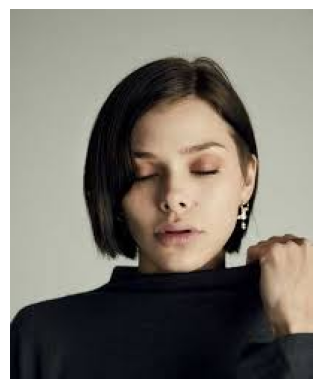

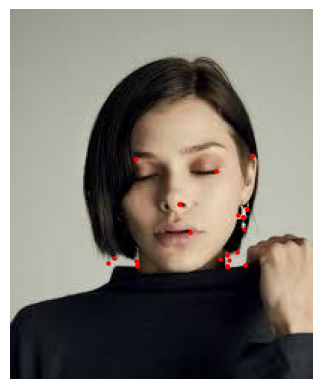

In [137]:
import torch
import torchvision
from kornia.feature import LocalFeatureMatcher, GFTTAffNetHardNet, DescriptorMatcher

# Supondo que 'device' já esteja definido, por exemplo, device = torch.device('cuda' ou 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
# Carregando a imagem, convertendo para float e normalizando
image1 = torchvision.io.read_image("image1.jpg").to(torch.float) / 255.0  # Normaliza para [0, 1]
plot_tensor(image1)

image1 = image1.to(device)

gftt_hardnet_matcher = LocalFeatureMatcher(
    GFTTAffNetHardNet(25), DescriptorMatcher('smnn', 0.8)
)

input = {"image0": image1[:1][None], "image1": image1[:1][None]}
out = gftt_hardnet_matcher(input)
plot_image_with_keypoints(image1,out['keypoints0'].detach())


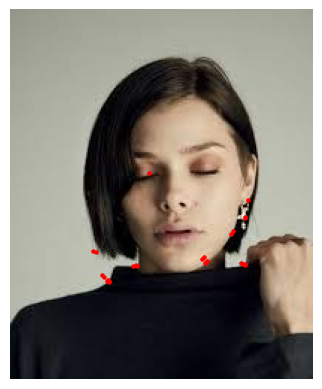

In [135]:
key_hardnet_matcher = LocalFeatureMatcher(
    KeyNetHardNet(25), DescriptorMatcher('smnn', 0.8)
)

input = {"image0": image1[:1][None], "image1": image1[:1][None]}
out = key_hardnet_matcher(input)
plot_image_with_keypoints(image1,out['keypoints0'].detach())

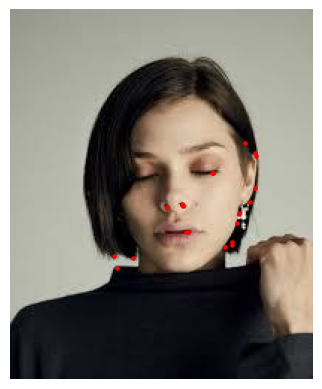

In [134]:
from kornia.feature import SIFTFeature
sift_hardnet_matcher = LocalFeatureMatcher(
    SIFTFeature(25), DescriptorMatcher('smnn', 0.8)
)

input = {"image0": image1[:1][None], "image1": image1[:1][None]}
out = sift_hardnet_matcher(input)
plot_image_with_keypoints(image1,out['keypoints0'].detach())

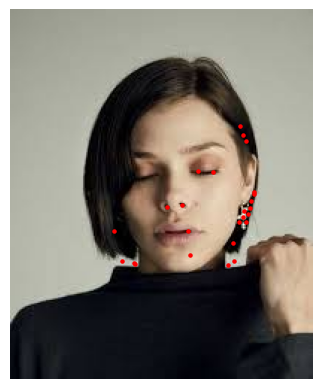

In [133]:
from kornia.feature import SIFTFeatureScaleSpace
sift_scale_matcher = LocalFeatureMatcher(
    SIFTFeatureScaleSpace(25), DescriptorMatcher('smnn', 0.8)
)

input = {"image0": image1[:1][None], "image1": image1[:1][None]}
out = sift_scale_matcher(input)
plot_image_with_keypoints(image1,out['keypoints0'].detach())